In [ ]:
"""
Purpose: To Run the proofreading of neurons in the 
test set and measure the precision and recall of the new rules

Segments to look out for that had no axon
864691135012395766 # one of the split segments files not there (split index = 1)
864691135865584005 #soma soma merger
864691136451113215 #it was an inhibitory neuron (part of split)

"""

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import datajoint as dj
import trimesh
from tqdm.notebook import tqdm
from pathlib import Path

from os import sys
sys.path.append("/meshAfterParty/")
sys.path.append("/meshAfterParty/meshAfterParty")

import datajoint_utils as du
from importlib import reload

INFO - 2021-07-08 17:02:55,936 - settings - Setting database.host to at-database.ad.bcm.edu
INFO - 2021-07-08 17:02:55,939 - settings - Setting database.user to celiib
INFO - 2021-07-08 17:02:55,940 - settings - Setting database.password to newceliipass
INFO - 2021-07-08 17:02:55,940 - settings - Setting database.host to at-database.ad.bcm.edu
INFO - 2021-07-08 17:02:55,941 - settings - Setting database.user to celiib
INFO - 2021-07-08 17:02:55,941 - settings - Setting database.password to newceliipass
INFO - 2021-07-08 17:02:55,945 - settings - Setting stores to {'minnie65': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65', 'stage': '/mnt/dj-stor01/platinum/minnie65'}, 'meshes': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65/02/meshes', 'stage': '/mnt/dj-stor01/platinum/minnie65/02/meshes'}, 'decimated_meshes': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65/02/decimated_meshes', 'stage': '/mnt/dj-stor01/platinum/minnie65/02/de

Connecting celiib@at-database.ad.bcm.edu:3306


INFO - 2021-07-08 17:02:56,543 - settings - Setting enable_python_native_blobs to True
INFO - 2021-07-08 17:02:56,596 - settings - Setting database.host to at-database.ad.bcm.edu
INFO - 2021-07-08 17:02:56,597 - settings - Setting database.user to celiib
INFO - 2021-07-08 17:02:56,598 - settings - Setting database.password to newceliipass
INFO - 2021-07-08 17:02:56,599 - settings - Setting enable_python_native_blobs to True
INFO - 2021-07-08 17:02:57,265 - settings - Setting enable_python_native_blobs to True
INFO - 2021-07-08 17:02:57,612 - settings - Setting database.host to at-database.ad.bcm.edu
INFO - 2021-07-08 17:02:57,614 - settings - Setting database.user to celiib
INFO - 2021-07-08 17:02:57,614 - settings - Setting database.password to newceliipass
INFO - 2021-07-08 17:02:57,615 - settings - Setting database.host to at-database.ad.bcm.edu
INFO - 2021-07-08 17:02:57,615 - settings - Setting database.user to celiib
INFO - 2021-07-08 17:02:57,616 - settings - Setting database.pa

In [3]:
#configuring will include the adapters
minnie,schema = du.configure_minnie_vm()

INFO - 2021-07-08 17:02:58,633 - settings - Setting database.host to at-database.ad.bcm.edu
INFO - 2021-07-08 17:02:58,634 - settings - Setting database.user to celiib
INFO - 2021-07-08 17:02:58,635 - settings - Setting database.password to newceliipass
INFO - 2021-07-08 17:02:58,638 - settings - Setting enable_python_native_blobs to True
INFO - 2021-07-08 17:02:59,576 - settings - Setting enable_python_native_blobs to True


In [4]:
import validation_utils as vu
import neuron_visualizations as nviz
import neuron_utils as nru
import proofreading_utils as pru
import time
import system_utils as su

In [130]:
bad_presyn_table = (minnie.AutoProofreadValidationScore6() & "pre_fp>10")
bad_presyn_table

ver materialization version,nucleus_id nucleus id,segment_id the segment id in the proofread version,old_ver materialization version,split_index the index of the neuron object that resulted AFTER THE SPLITTING ALGORITHM,decomposition saved neuron object with high fidelity axon,axon_length axon length of the filtered neuron,validation_df,validation_df_ext,pre_tp,pre_tn,pre_fp,pre_fn,pre_precision,pre_recall,pre_f1,post_tp,post_tn,post_fp,post_fn,post_precision,post_recall,post_f1,run_time the amount of time to run (seconds)
88.00,230236,864691135609687047,0.08,0,=BLOB=,1343.99235047008,=BLOB=,=BLOB=,27,549,12,23,0.6923076923076923,0.54,0.6067415730337079,1960,22,1,2,0.9994900560938297,0.9989806320081549,0.99923527912312,958.53
88.00,301095,864691135446675028,0.08,0,=BLOB=,875.6817477151404,=BLOB=,=BLOB=,8,390,11,7,0.42105263157894735,0.5333333333333333,0.47058823529411764,3322,8,6,27,0.9981971153846154,0.9919378919080323,0.9950576606260296,423.79
88.00,493968,864691135117980637,0.08,0,=BLOB=,1809.3865846190454,=BLOB=,=BLOB=,46,623,24,16,0.6571428571428571,0.7419354838709677,0.6969696969696969,3600,2,49,3,0.9865716634694437,0.9991673605328892,0.9928295642581357,849.42
88.00,518853,864691135415666362,0.08,0,=BLOB=,3282.216896102451,=BLOB=,=BLOB=,293,475,34,42,0.8960244648318043,0.8746268656716418,0.8851963746223565,9304,4,3,5,0.9996776619748576,0.99946288537974,0.9995702621400945,1287.22
88.00,533187,864691136227020113,0.08,0,=BLOB=,713.7785339803089,=BLOB=,=BLOB=,0,113,18,0,0.0,nan,nan,1,9,2595,0,0.0003852080123266564,1.0,0.0007701193685021179,602.7
88.00,554775,864691135593719339,0.08,0,=BLOB=,1138.6029649457212,=BLOB=,=BLOB=,29,82,12,0,0.7073170731707317,1.0,0.8285714285714285,4430,2,5,1,0.9988726042841037,0.9997743173098623,0.9993232573877736,408.61
88.00,558684,864691136378859477,0.08,0,=BLOB=,1668.3578259229862,=BLOB=,=BLOB=,4,279,13,1,0.23529411764705882,0.8,0.3636363636363636,3465,9,1,36,0.9997114829774957,0.9897172236503856,0.9946892493182145,5519.72
88.00,582412,864691135753917645,0.08,0,=BLOB=,511.48427849134845,=BLOB=,=BLOB=,12,151,11,32,0.5217391304347826,0.2727272727272727,0.3582089552238806,3048,23,622,23,0.8305177111716622,0.9925105828720286,0.9043168669336894,1328.5
88.00,582444,864691135571017453,0.08,0,=BLOB=,1059.9712133374048,=BLOB=,=BLOB=,18,107,18,2,0.5,0.9,0.6428571428571429,6500,1,1,2,0.9998461775111521,0.9996924023377423,0.999769284011382,512.39
88.00,608166,864691135864188286,0.08,0,=BLOB=,1418.571318717418,=BLOB=,=BLOB=,39,179,12,2,0.7647058823529411,0.9512195121951219,0.8478260869565216,6694,15,8,11,0.9988063264697106,0.9983594332587621,0.9985828298649959,1671.66


# Look at certain neuron after processing

In [152]:
segment_id = 864691135117980637
segment_id = 864691135415666362
segment_id = 864691136227020113
segment_id = 864691135571017453
segment_id = 864691135609687047
segment_id = 864691136227020113
segment_id = 864691135415666362
curr_table = (minnie.AutoProofreadValidationScore6() & dict(segment_id=segment_id))
decomp_path,validation_df = curr_table.fetch1("decomposition","validation_df")
neuron_obj = du.filepath_to_neuron_obj(decomp_path)

Decompressing Neuron in minimal output mode...please wait


In [153]:
curr_table

ver materialization version,nucleus_id nucleus id,segment_id the segment id in the proofread version,old_ver materialization version,split_index the index of the neuron object that resulted AFTER THE SPLITTING ALGORITHM,decomposition saved neuron object with high fidelity axon,axon_length axon length of the filtered neuron,validation_df,validation_df_ext,pre_tp,pre_tn,pre_fp,pre_fn,pre_precision,pre_recall,pre_f1,post_tp,post_tn,post_fp,post_fn,post_precision,post_recall,post_f1,run_time the amount of time to run (seconds)
88.00,518853,864691135415666362,0.08,0,=BLOB=,3282.216896102451,=BLOB=,=BLOB=,293,475,34,42,0.8960244648318043,0.8746268656716418,0.8851963746223565,9304,4,3,5,0.9996776619748576,0.99946288537974,0.9995702621400945,1287.22


In [154]:
minnie.AutoProofreadValidationSegmentMap4 & dict(segment_id=864691135609687047)

ver materialization version,nucleus_id nucleus id,segment_id the segment id in the proofread version,old_ver materialization version,old_segment_id the segment id in the proofread version--,finished_dendrite whether axon was finished cleaning,finished_axon whether axon was finished cleaning,extension_type,n_somas,n_soma_mergers,n_glia,large_splits,notes
88.00,230236,864691135609687047,0.08,864691135748568361,True,True,full,1,0,0,0,


In [155]:
# nviz.visualize_neuron(neuron_obj,
#                      limb_branch_dict="all")

In [156]:
return_validation_df_revised = vu.load_df_val_from_numpy(validation_df)
filt_neuron = neuron_obj
vu.plot_validation_synapses(filt_neuron.segment_id,
                            validation_df = return_validation_df_revised,
                             synapse_dict = None,
                             synapses_type_to_plot = None,
                             synapses_type_to_not_plot = None,
                             verbose=False,
                             synapse_type = "presyn",
                             TP_color="yellow",
                            TN_color="aqua",
                            FP_color="black",
                            FN_color="orange",
                             synapse_scatter_size = 0.15,
                             
                             #for plotting the actual mesh parts to go along
                             
                             neuron_obj = filt_neuron,
                             plot_only_axon_skeleton = True,
                             error_mesh_color = "red",
                             valid_mesh_color = "green",
                             valid_skeleton_color = "black",
                             mesh_alpha = 0.3,)

Using the mesh from the neuron object


TP:yellow
TN:aqua
FP:black
FN:orange


In [157]:
import validation_utils as vu
vu.FP_limb_branches_from_validation_df(
    validation_df = return_validation_df_revised,
    neuron_obj = neuron_obj,
    )

[array([[  1,  18],
        [  1,  51],
        [  1,  52],
        [  1,  55],
        [  1,  66],
        [  1, 170]]),
 [[1, 18], [1, 55], [1, 66], [1, 170]],
 {1: [[66], [170], [18], [51, 52, 55]]}]

In [160]:
nru.upstream_node(neuron_obj[1],55)

68

In [162]:
ed.debug_branches_low_degree(neuron_obj,[68],filters_to_run=[gf.fork_min_skeletal_distance_filter])



 ----- Working on branch 68/228: 68--------
downstream_branches = [64 55]
skipped_nodes = []
Total number of short_thick_endnodes_to_remove = 18
downstream_branches after remove_short_thick_endnodes = [55 64]
Total number of axon_spines = 64
downstream_branches after remove_short_thick_endnodes = [55 64]
widths_in_branches = [ 53.94443626  60.24775943 133.40108024]
Running local filtering for branch 68

--- After Edge Attributes ---


  0%|          | 0/3 [00:00<?, ?it/s]

    u   v  sk_angle  width_diff  width_diff_percentage  synapse_density_diff  \
0  55  64    123.58    2.041221               0.037839              0.000118   
1  55  68     41.63   79.456644               0.595622              0.000190   
2  64  68     26.86   77.415423               0.580321              0.000072   

   n_synapses_diff  
0                9  
1               10  
2                1  

--- After node attributes ---
    u   node_type  skeletal_length_downstream  \
0  55  downstream                52542.091322   
1  64  downstream                32921.055837   
2  68    upstream                         NaN   

   skeletal_length_downstream_total  width_downstream  n_synapses_downstream  \
0                     134420.951461         53.944436                   10.0   
1                     229830.900526         60.247759                    1.0   
2                               NaN               NaN                    NaN   

   n_synapses_downstream_total  skeletal_lengt

min_dist= 1376.070627054224
distances_between_skeletons = [2033.83153276 2131.45992381 2497.86724583 2583.84604095 2229.40749326
 2411.29125048 1942.00410548 2325.54842142 2670.82847973 2767.36465313
 1881.11392308 1827.92199683 1770.57707685 1701.08353863 1634.33655299
 1608.76317533 1376.07062705 1408.55703178 1467.68775461 1594.58631341
 1536.99504678]
return_value = 1376.070627054224
div = 1376.070627054224 with threshold set to 1500
error_check = True
error_branches = [55, 64]
filter_triggered = fork_min_skeletal_distance_filter, error_branches = [55, 64]
68 triggered fork_min_skeletal_distance_filter
error_downstream = [55 64],triggered_filter = fork_min_skeletal_distance_filter 


{'L1': array([55, 64])}

In [141]:
neuron_obj.segment_id

864691135748568361

In [138]:
nviz.plot_limb_path(neuron_obj[0],[28]
                   )

limb_name = L0
Recieved another instance of Neuron class in init -- so just copying data

 Working on visualization type: mesh

 Working on visualization type: skeleton
No Synapses to plot


No limb name was given so using L0 because was the limb in the first key


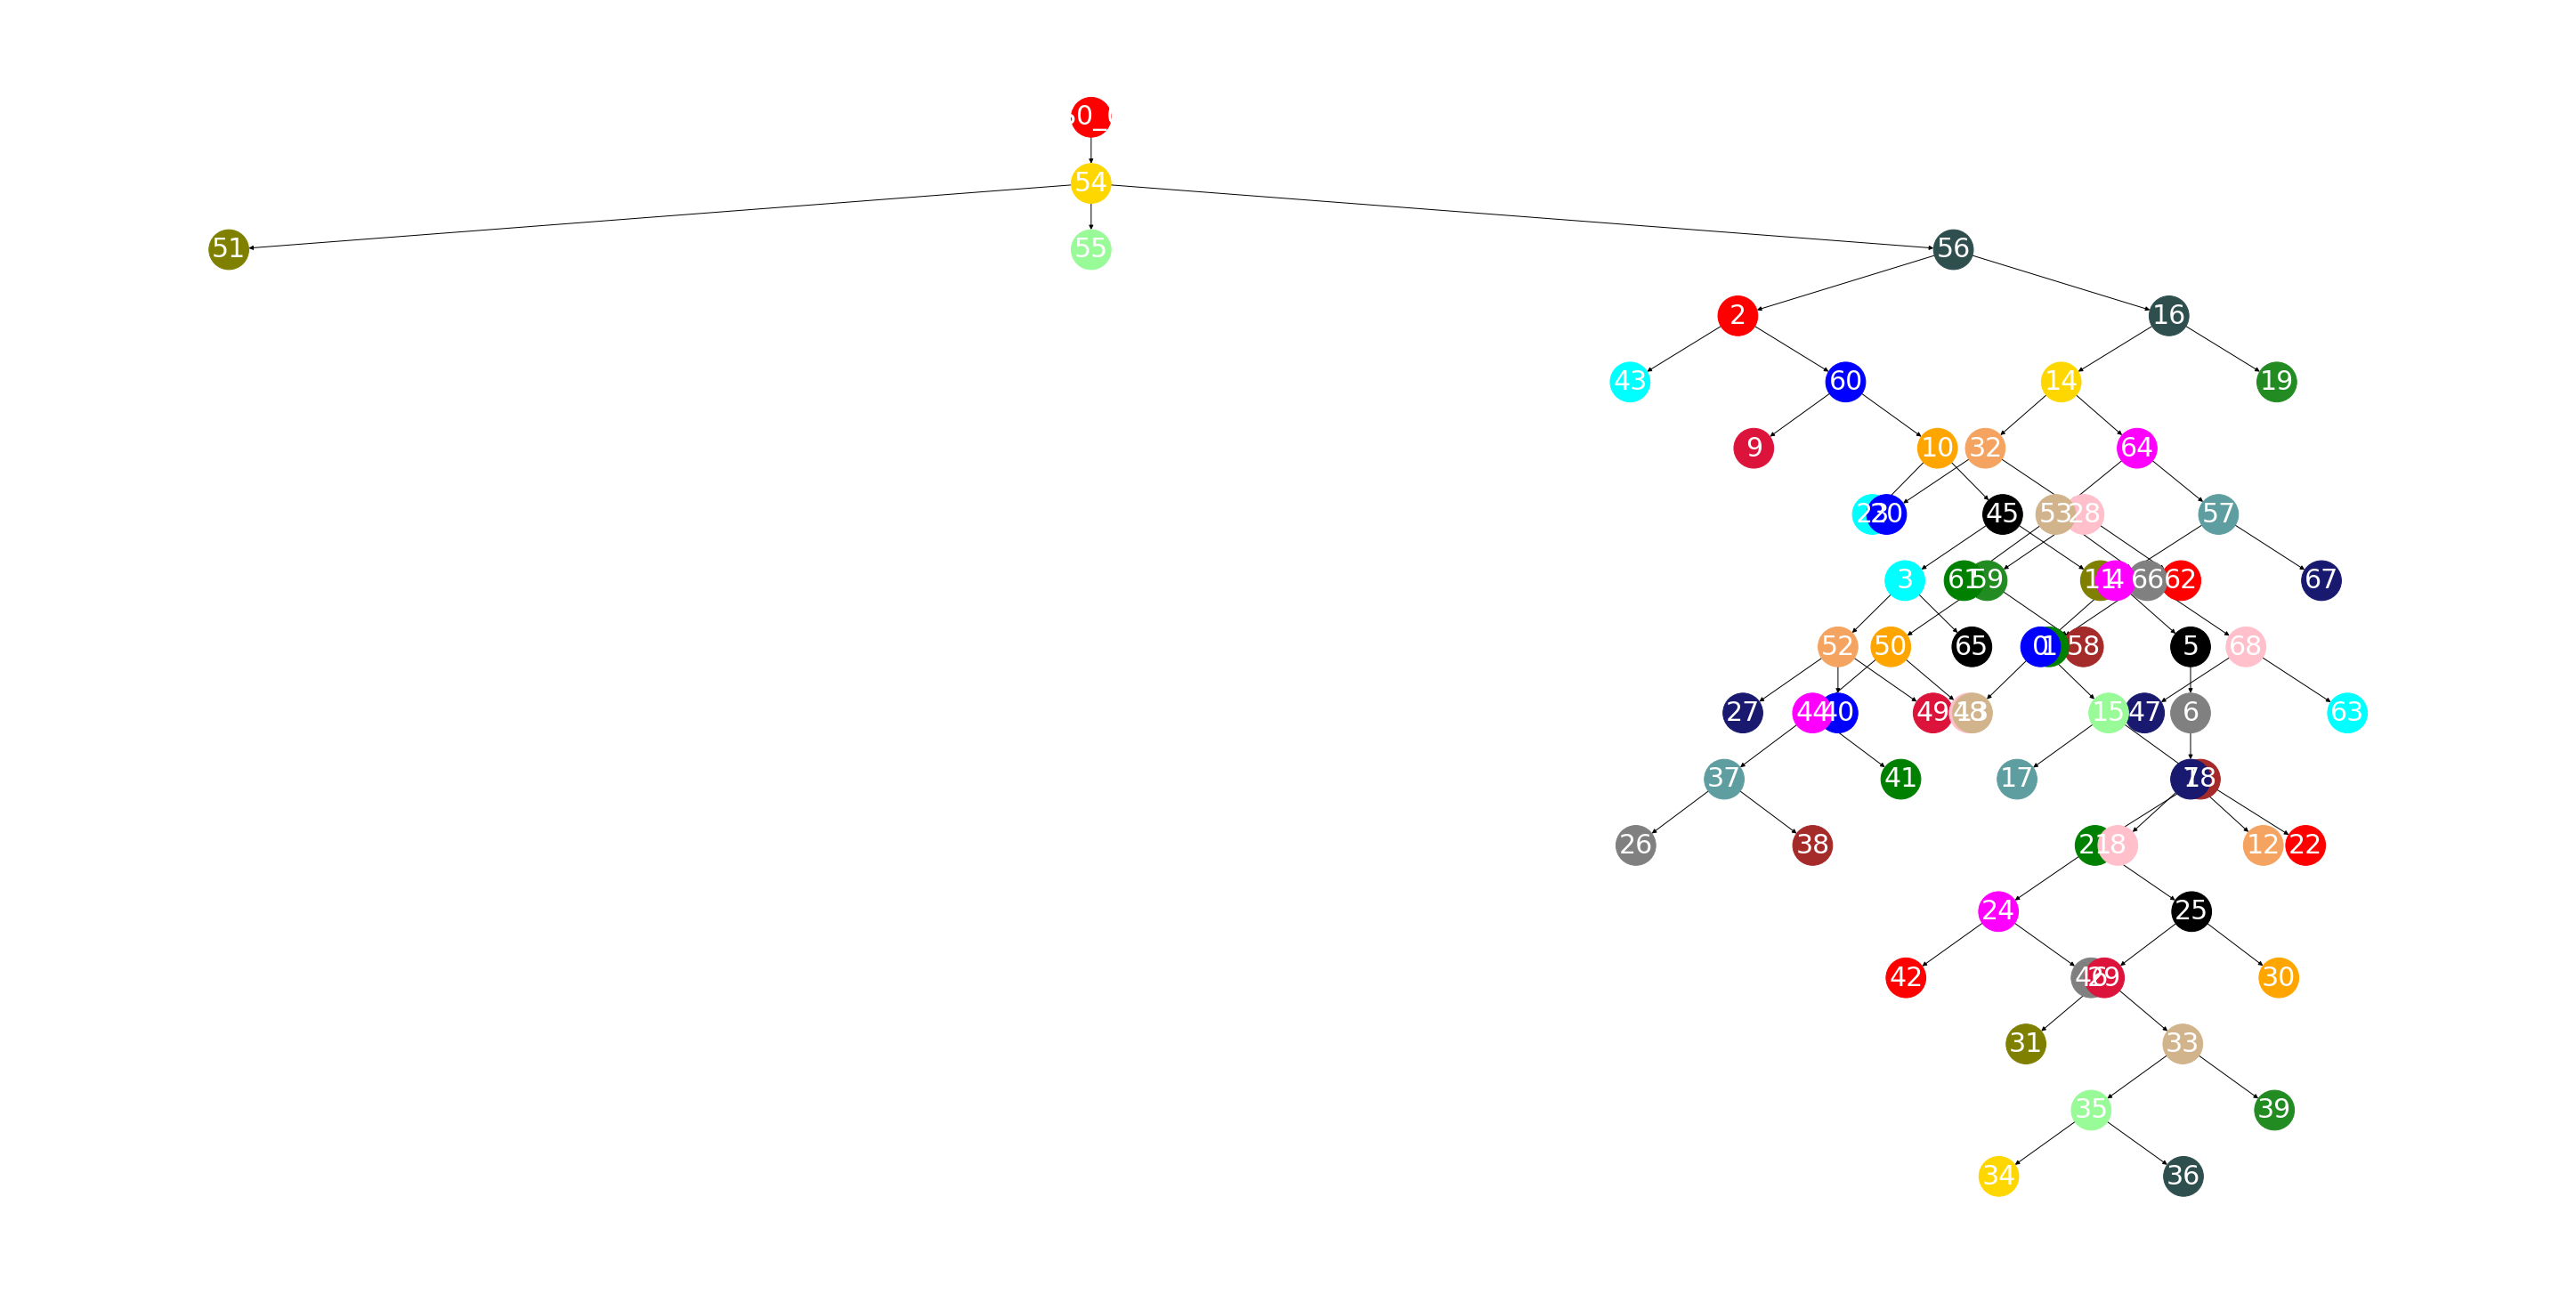

In [137]:
nviz.visualize_neuron_specific_limb(neuron_obj,
                                   "axon")

# Debugging one of the divergences

In [ ]:
import graph_filters as gf
ed.low_degree_branch_errors_limb_branch_dict(neuron_obj,
                                         filters_to_run = [gf.fork_min_skeletal_distance_filter],
                                         #debug_branches=[68]
                                            )

# Getting all of the scores

In [ ]:
minnie.AutoProofreadValidationScore6()

In [ ]:
minnie,_ = du.configure_minnie_vm()
validation_dfs = minnie.AutoProofreadValidationScore6().fetch("validation_df")
validation_dfs = [vu.load_df_val_from_numpy(k) for k in validation_dfs]
validation_dfs

In [ ]:
import pandas_utils as pu
total_validation_df = pu.concat(validation_dfs)
total_validation_df
vu.synapse_validation_df_to_score_plot(total_validation_df)

# Looking at a certain neuron

In [ ]:
#segment_id = 864691135945413668
#segment_id = 864691136951664863
segment_id = 864691135740225387
segment_id = 864691136008425132

segment_id = 864691136311791677
neuron_objs,neuron_split_idxs = du.decomposition_with_spine_recalculation(segment_id)

In [ ]:
neuron_obj = neuron_objs[0]
print(neuron_obj.axon_limb_branch_dict)
nviz.plot_axon(neuron_obj)

In [ ]:
inh_exc_class = "excitatory"
plot_limb_branch_filter_with_disconnect_effect = True
perform_axon_classification = False
verbose = True
filtered_neuron,filtering_info = pru.proofread_neuron_class_predetermined(neuron_obj,
        inh_exc_class=inh_exc_class,
        perform_axon_classification=False,

        plot_limb_branch_filter_with_disconnect_effect = plot_limb_branch_filter_with_disconnect_effect,


        plot_final_filtered_neuron = False,

        #arguments for the axon high fidelity:
        plot_new_axon_limb_correspondence = False,
        plot_new_limb_object = False,
        plot_final_revised_axon_branch = False,

        verbose = False,
        verbose_outline = verbose,
        #filter_list = filter_list
        filter_list = pru.v6_exc_filters(),
        #filter_list = [pru.exc_high_degree_branching_filter_v6],
        high_fidelity_axon_on_excitatory = perform_axon_classification,
                                                                             )

In [ ]:
debug

In [ ]:
d_skeletons_resized = [sk.resize_skeleton_branch(k,segment_width=50)
                          for k in downstream_skeletons]
joining_endpoint_1 = np.array([822357. , 785765.2, 939390.7])
joining_endpoint_1
comparison_distance = 2000

In [ ]:
d_skeletons_restricted = [sk.restrict_skeleton_to_distance_from_coordinate(k,
                                             coordinate = joining_endpoint_1,
                                             distance_threshold = comparison_distance+1,)
                              for k in d_skeletons_resized]

In [ ]:
import system_utils as su
downstream_skeletons = su.decompress_pickle("downstream_skeletons")

In [ ]:
import skeleton_utils as sk
sk.shared_coordiantes(list(downstream_skeletons),
                             return_one=True)

In [ ]:
nviz.plot_objects(skeletons=downstream_skeletons,
                 scatters=[np.array([822357. , 785765.2, 939390.7])])

In [ ]:
sk.find_skeleton_endpoint_coordinates(downstream_skeletons[0]),sk.find_skeleton_endpoint_coordinates(downstream_skeletons[1])

In [ ]:
limb_obj = neuron_obj[neuron_obj.axon_limb_idx]
limb_obj

In [ ]:
nru.upstream_endpoint(limb_obj,402)

In [ ]:
nru.downstream_endpoint(limb_obj,402)

In [ ]:
nru.restrict_skeleton_from_start_plus_offset_upstream(limb_obj,
                                                      402,
                                                      verbose=True
                                                     )

In [ ]:
import system_utils as su

In [ ]:
restrict_skeleton_from_start_plus_offset_downstream

In [ ]:
test_sk = su.decompress_pickle("test_sk.pbz2")

In [ ]:
.endpoints

In [ ]:
branch_obj = neuron_obj[0][20]
nviz.plot_objects(skeletons=[branch_obj.skeleton],
                  meshes=[branch_obj.mesh],
                 scatters=[branch_obj.endpoints])

In [ ]:
import error_detection as ed
arg_dict = dict(child_width_maximum = 75,
                                        parent_width_maximum = 75,
                                         axon_only = True,
                                         error_if_web_is_none=True,
                                         web_size_threshold=120,
                                        web_size_type="ray_trace_median",
                                        web_above_threshold = True,
                                           ignore_if_child_mesh_not_touching = True )
ed.webbing_t_errors_limb_branch_dict(neuron_obj,verbose = True,plot_web_errors = True,**arg_dict)

In [ ]:
limb_obj = neuron_obj[0]

In [ ]:
import trimesh_utils as tu
import numpy_utils as nu

In [ ]:
downstream_nodes = [10,148]
upstream_node = 147

upstream_node = 13


downstream_nodes_mesh_connected(limb_obj,147,
                               verbose=True)

In [ ]:
intersect_array = nu.intersect2d([],np.array([[0,1],[0,2]]))
intersect_array

In [ ]:
downstream_nodes

In [ ]:
meshes=[limb_obj[k].mesh for k in downstream_nodes + [upstream_node]]
nviz.plot_objects(meshes=meshes)

In [ ]:
nviz.plot_branch_groupings(limb_obj,
                          [[upstream_node],downstream_nodes],)

In [ ]:
minnie.AutoProofreadValidationSegmentMap4() & dict(segment_id=864691136951664863)

# Runnig the validation

In [ ]:
"""
Psueodocode: 
1) Pull down the segment ids of the valid neurons

For each neuron
1) Dwonload the neuron object
2) Run the Proofreading
3) Print out the validation plot
4) Save the validation df

"""

In [ ]:
"""
Pseudocode: 
1) Check if there are multiple somas associated with that segment

"""

In [ ]:
axon_segs = dj.U("segment_id") & (minnie.DecompositionAxon() 
                      & minnie.AutoProofreadValidationSegment4() - minnie.AutoProofreadValidationSegmentExclude4() )
axon_segs

In [ ]:
"""
Pseudocode: 
1) Find the coordinates of the nucleus for that new segment
2) Make sure that same number of DecompositionAxon objects as in Decomposition
3) Pick the neuron object that is closest and within a certain range of the nucleus
4) Download the neuron object
5) Run the proofreading
6) Save off the validation df
"""

In [ ]:
minnie.AutoProofreadValidationScore5()

In [ ]:
bad_postsyn_table = (minnie.AutoProofreadValidationScore5() & "post_fn>200")
bad_postsyn_table_filt =  (bad_postsyn_table * minnie.AutoProofreadValidationSegmentMap4()) & axon_segs.proj(old_segment_id="segment_id")
#bad_postsyn_seg_ids = bad_postsyn_table.fetch("segment_id")
bad_postsyn_table_filt.proj("post_fn")

In [ ]:
minnie.AutoProofreadValidationScore6()

In [ ]:
import datajoint as dj
dj.config["display.limit"] = 30
bad_presyn_table = (minnie.AutoProofreadValidationScore5() & "pre_fp>10")
bad_presyn_seg_ids = bad_presyn_table.fetch("segment_id")
bad_presyn_table

In [ ]:
# multi_soma_keys = (minnie.AutoProofreadValidationSegmentMap4() & "n_somas>1"
#                       & minnie.DecompositionAxon.proj(old_segment_id="segment_id")
#                   & dict(segment_id = 864691135415710906)).proj().fetch(as_dict=True)
# key = multi_soma_keys[0]
# key

In [ ]:
segment_id = 864691135117980637
key = dict(segment_id=segment_id)

In [ ]:
verbose = True

segment_id=key["segment_id"]
print(f"\n-- Working on neuron {segment_id}---")

segment_map_dict = (minnie.AutoProofreadValidationSegmentMap4() & key).fetch1()

#1) Find the coordinates of the nucleus for that new segment
nucleus_id = segment_map_dict["nucleus_id"]
nuc_center_coords = du.nuclei_id_to_nucleus_centers(nucleus_id)
if verbose:
    print(f"nuc_center_coords = {nuc_center_coords}")

#2) Make sure that same number of DecompositionAxon objects as in Decomposition
old_segment_id = segment_map_dict["old_segment_id"]
if verbose:
    print(f"old_segment_id = {old_segment_id}")
    
search_key = dict(segment_id=old_segment_id)
n_somas = len(minnie.BaylorSegmentCentroid() & search_key)
n_decomp_axon = len(minnie.DecompositionAxon() & search_key)
if verbose:
    print(f"# of somas = {n_somas} and # of DecompositionAxon = {n_decomp_axon}")
    

if n_somas != n_decomp_axon:
    raise Exception(f"# of somas = {n_somas} NOT MATCH # of DecompositionAxon = {n_decomp_axon}")
    
#3) Pick the neuron object that is closest and within a certain range of the nucleus
neuron_objs,split_idxs = du.decomposition_with_spine_recalculation(old_segment_id)
if n_somas > 1:
    """
    Finding the closest soma:
    1) For each neuron object get the mesh center of the soma object
    2) Find the distance of each from the nucleus center
    3) Find the arg min distance and make sure within threshold
    4) Mark the current neuron and the current split index
    """
    nuclei_distance_threshold = 15000

    soma_center_coords = [k["S0"].mesh_center for k in neuron_objs]
    soma_distances = [np.linalg.norm(k-nuc_center_coords) for k in soma_center_coords]
    min_dist_arg = np.argmin(soma_distances)
    min_dist = soma_distances[min_dist_arg]

    if verbose:
        print(f"soma_distances = {soma_distances}")
        print(f"min_dist_arg = {min_dist_arg}, with min distance = {min_dist}")

    if min_dist > nuclei_distance_threshold:
        raise Exception(f"min_dist ({min_dist}) larger than nuclei_distance_threshold ({nuclei_distance_threshold})")

    neuron_obj = neuron_objs[min_dist_arg]
    split_index = split_idxs[min_dist_arg]

    if verbose:
        print(f"Winning split_index = {split_index}")
else:
    split_index = split_idxs[0]
    neuron_obj = neuron_objs[0]
    
    
import proofreading_utils as pru
import validation_utils as vu
(filt_neuron,
     return_synapse_df_revised,
     return_synapse_df_errors,
    return_validation_df_revised,
    return_validation_df_extension) =  vu.filtered_neuron_score(neuron_obj = neuron_obj,   
                        filter_list = pru.v5_exc_filters(),
                        plot_limb_branch_filter_with_disconnect_effect = True,
                        verbose = True,
                        plot_score=False,
                        nucleus_id = nucleus_id,
                        return_synapse_df_errors=True,
                        return_validation_df_extension = True,                                        
                        split_index=split_index)
    

In [ ]:
vu.synapse_validation_df_to_score_plot(return_validation_df_revised)

In [ ]:
nviz.plot_axon(filt_neuron)

In [ ]:
# import neuron_visualizations as nviz
# nviz.visualize_neuron(filt_neuron,
#                       limb_branch_dict="all")

In [ ]:
minnie.AutoProofreadValidationSegmentMap4() & key

In [ ]:
filt_neuron.segment_id

In [ ]:
vu.plot_validation_synapses(filt_neuron.segment_id,
                            validation_df = return_validation_df_revised,
                             synapse_dict = None,
                             synapses_type_to_plot = None,
                             synapses_type_to_not_plot = None,
                             verbose=False,
                             synapse_type = "presyn",
                             TP_color="yellow",
                            TN_color="aqua",
                            FP_color="black",
                            FN_color="orange",
                             synapse_scatter_size = 0.15,
                             
                             #for plotting the actual mesh parts to go along
                             
                             neuron_obj = filt_neuron,
                             plot_only_axon_skeleton = True,
                             error_mesh_color = "red",
                             valid_mesh_color = "green",
                             valid_skeleton_color = "black",
                             mesh_alpha = 0.3,)

# How to attach the synapses

In [ ]:
beginning_direct_connections = du.segment_id_to_synapse_table(filt_neuron.segment_id,
                                                                         validation=True)
beginning_direct_connections

In [ ]:
864691135584074360

# Debugging the Stitch Distance

In [ ]:
incorp_floating_pieces = nru.non_soma_touching_meshes_stitched(filt_neuron)
incorp_floating_pieces

In [ ]:
nviz.plot_objects(meshes = incorp_floating_pieces)

In [ ]:
nru.filter_branches_by_restriction_mesh(filt_neuron[2],
                                       restriction_mesh=incorp_floating_pieces[0])

In [ ]:
[k for k in dir(nru) if "mesh" in k]

In [ ]:
nru.find_parent_child_skeleton_angle(filt_neuron[2],68,
                                     comparison_distance=5000,
                                     offset=0,
                                    plot_extracted_skeletons=True)

In [ ]:
nru.upstream_node(filt_neuron[2],68)

In [ ]:
nviz.plot_limb_path(filt_neuron[2],[68])

In [ ]:
nviz.visualize_neuron_specific_limb(filt_neuron,
                                   filt_neuron.axon_limb_idx)

In [ ]:
minnie.AutoProofreadStats5()

In [ ]:
du.plot_proofread_neuron(864691135517422218,
                         plot_proofreading_synapses=True,
                        plot_errored_faces=True)

# Checking the long Axons

In [ ]:
du.proofreading_neurons_table() & "axon_length>2000" & "spine_category='densely_spined'"

In [ ]:
du.plot_proofread_neuron(864691134917429770,
                        plot_proofreading_synapses=True)

In [ ]:
import ipyvolume as ipv
ipv.gcf()

In [ ]:
ipv.pylab.save("864691134917429770_proof_v5.html")

In [ ]:
du.plot_proofread_mesh_skeleton(864691134917429770)

In [ ]:
minnie,_ = du.configure_minnie_vm()
from importlib import reload
du = reload(du)